In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from ipynb.fs.full.utility_functions import gen_data_dict, get_data, error_count, opart, show_error_rate

np.random.seed(4)
torch.manual_seed(4)

In [2]:
# Hyper
n_ite = 60

In [3]:
def downsize_df(df, downsize):
    return df.groupby(['sequenceID', df.groupby('sequenceID').cumcount() // downsize]).agg({'data.i': 'first', 'logratio': 'mean'}).reset_index(level=1, drop=True).reset_index()

In [4]:
# sequences
seqs = gen_data_dict('0_sequences_labels/signals.gz')
labels = gen_data_dict('0_sequences_labels/labels.gz')

# target
target_df_1 = pd.read_csv('1_training_data/target_lambda_fold1_base_e.csv')
target_df_2 = pd.read_csv('1_training_data/target_lambda_fold2_base_e.csv')

targets_low_1  = target_df_1.iloc[:, 1:2].to_numpy()
targets_high_1 = target_df_1.iloc[:, 2:3].to_numpy()
targets_low_2  = target_df_2.iloc[:, 1:2].to_numpy()
targets_high_2 = target_df_2.iloc[:, 2:3].to_numpy()

targets_low_1  = torch.FloatTensor(targets_low_1)
targets_high_1 = torch.FloatTensor(targets_high_1)
targets_low_2  = torch.FloatTensor(targets_low_2)
targets_high_2 = torch.FloatTensor(targets_high_2)

y1_raw = torch.cat((targets_low_1, targets_high_1), dim=1)
y2_raw = torch.cat((targets_low_2, targets_high_2), dim=1)

In [5]:
# filter
idx_fold1 = [idx for idx, item in enumerate(y1_raw) if item[0] > -np.inf and item[1] < np.inf]
X1 = [seqs[i] for i in idx_fold1]
y1 = torch.mean(y1_raw[idx_fold1], axis=1).reshape(-1,1)

idx_fold2 = [idx for idx, item in enumerate(y2_raw) if item[0] > -np.inf and item[1] < np.inf]
X2 = [seqs[i] for i in idx_fold2]
y2 = torch.mean(y2_raw[idx_fold2], axis=1).reshape(-1,1)

In [6]:
# for i in idx_fold1:
#     print("i:%2d \t seqID:%10s \t man_x:%4.2f \t length:%5d \t new_length:%3d "%(i, seqs[i][0] , manual_X[i].item(), len(seqs[i][1]), len(downsized_seqs[i][1])))

In [7]:
print(len(X1), len(y1))
print(len(X2), len(y2))

190 190
313 313


In [8]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, extracted_features, hidden_layers, hidden_size):
        super(RNNModel, self).__init__()
        # M1
        self.rnn        = nn.RNN(input_size=1, hidden_size=extracted_features, num_layers=1, nonlinearity='tanh', bias=True, batch_first=False)
        # M2
        self.hidden_layers = hidden_layers
        self.hidden_size   = hidden_size
        # Define input layer
        self.input_layer = nn.Linear(extracted_features, hidden_size)
        # Define hidden layers
        self.hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers)])
        # Define output layer
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # M1
        _, x = self.rnn(x)
        # M2
        # Forward pass through input layer
        x = torch.relu(self.input_layer(x))
        # Forward pass through hidden layers
        for layer in self.hidden:
            x = torch.relu(layer(x))
        # Forward pass through output layer
        x = self.output_layer(x)

        return x

In [9]:
def plot_loss(train_loss, val_loss, train_set_name, test_set_name):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    # Find the index of the minimum validation loss
    min_val_loss_index = val_loss.index(min(val_loss))
    min_val_loss = val_loss[min_val_loss_index]
    
    # Mark the minimum validation loss point
    plt.plot(min_val_loss_index + 1, min_val_loss, 'g*', markersize=10, label=f'Min Val epoch: {min_val_loss_index: 3d}')

    plt.title('Train ' + train_set_name + " Validate " + test_set_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
def train_model(X, y, X_test, y_test, extracted_features, n_hiddens, layer_size, n_ites):
    model = RNNModel(extracted_features=extracted_features, hidden_layers=n_hiddens, hidden_size=layer_size)
    loss_func = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    train_losses = []
    val_losses = []
    for i in range(n_ites+1):
        loss_sum = 0.0
        val_loss_sum = 0.0

        for j in range(len(X)):
            model.train()
            optimizer.zero_grad()

            seq = torch.tensor(X[j][1]['logratio'].to_numpy(), dtype=torch.float32).reshape(-1, 1)
            output = model(seq)
            loss = loss_func(output[0], y[j])
            loss_sum += loss.item()

            loss.backward()
            optimizer.step()

        train_losses.append(loss_sum / len(X))

        with torch.no_grad():
            for k in range(len(X_test)):
                seq = torch.tensor(X_test[k][1]['logratio'].to_numpy(), dtype=torch.float32).reshape(-1, 1)
                val_output = model(seq)
                val_loss = loss_func(val_output[0], y_test[k])
                val_loss_sum += val_loss.item()
            val_losses.append(val_loss_sum / len(y_test))
        
        # print("epoch: %d \t train_loss: %7.5f \t test_loss: %7.5f" % (i, loss_sum/len(X), val_loss_sum/len(y_test)))
    
    return model, train_losses, val_losses

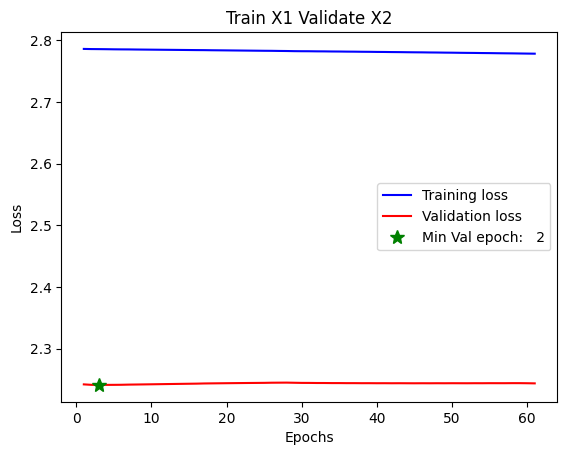

In [11]:
model, train_losses, val_losses = train_model(X1, y1, X2, y2, 4, 0, 4, n_ite)
plot_loss(train_losses, val_losses, train_set_name='X1', test_set_name='X2')

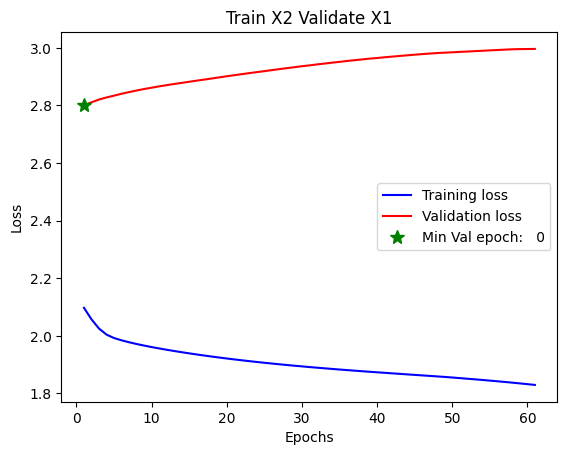

In [12]:
model, train_losses, val_losses = train_model(X2, y2, X1, y1, 4, 0, 4, n_ite)
plot_loss(train_losses, val_losses, train_set_name='X2', test_set_name='X1')

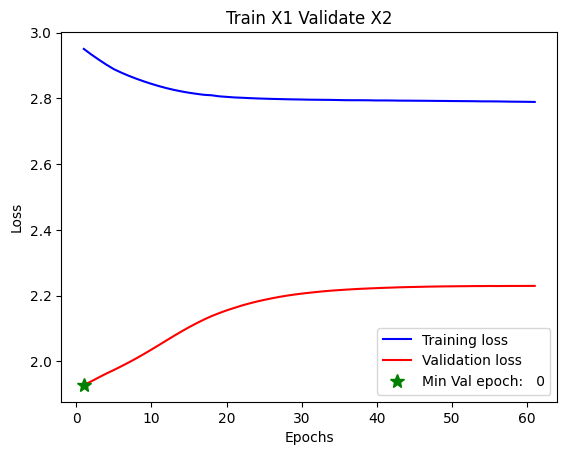

In [13]:
model, train_losses, val_losses = train_model(X1, y1, X2, y2, 12, 2, 16, n_ite)
plot_loss(train_losses, val_losses, train_set_name='X1', test_set_name='X2')

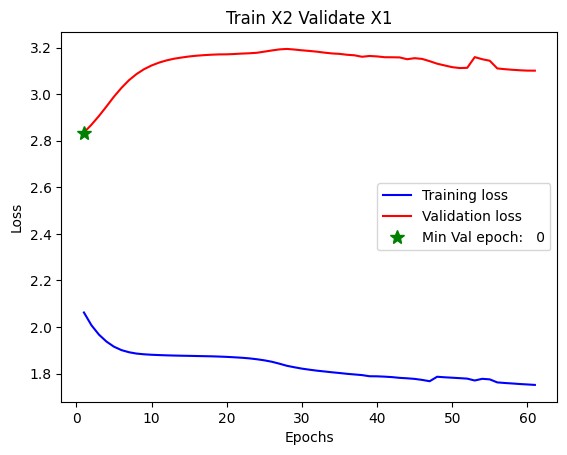

In [14]:
model, train_losses, val_losses = train_model(X2, y2, X1, y1, 12, 2, 16, n_ite)
plot_loss(train_losses, val_losses, train_set_name='X2', test_set_name='X1')